# Training BERT, SciBERT and PubMedBERT

## 0. Setup

### 0.1 Install libraries

In [2]:
! pip install -r requirements.txt


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### 0.2 GPU setup

In [3]:
# Check if CUDA is available and print the current device's name
import torch
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.current_device())
    print(torch.cuda.get_device_name(0))

True
0
NVIDIA GeForce RTX 2070 with Max-Q Design


## 1. Configuration

In [4]:
data_path = r"../../data/labeled/2025-06-28_labeled_data.xlsx"
text_column_name = "expanded"
label_column_name = "label_strict"

model_name = "bert-base-uncased" # standard; I specify other models in the "3. Initialize Models" section of this script
test_size = 0.2
num_labels = 2

## 2. Read and prepare dataset

In [5]:
import pandas as pd

# Load the data
df = pd.read_excel(data_path)

# Remove all columns but 'expanded' and 'label_strict'
df = df.drop(columns=['statement_id', 'section', 'header','div', 'p', 's', 'article_id', 'p_comp', 'p_value', 'context', 'text', 'label_kind', 'label_keywords', 'label_comment'])

# Change column names
df = df.rename(columns={text_column_name: 'text', label_column_name: 'label'})

# Remove rows where 'label' is NA or -99
df = df[~df['label'].isna() & (df['label'] != -99)]

# Convert label column to int (required for classification)
df['label'] = df['label'].astype(int)

# Balance the dataset: all 1s and an equal number of random 0s
ones = df[df['label'] == 1]
zeros = df[df['label'] == 0].sample(n=len(ones), random_state=42)
df = pd.concat([ones, zeros]).sample(frac=1, random_state=42).reset_index(drop=True)

# Show head
df.head()

,text,label
0,The learning bias for the self condition and t...,0
1,"During habituation, the D1 component did not d...",1
2,No significant interaction was found when we c...,0
3,"Contrary to our prediction, results showed tha...",0
4,Higher income was not associated with decrease...,1


### 2.1 Create Train/Test set

In [6]:
from sklearn.model_selection import train_test_split

# Separate by label
ones = df[df['label'] == 1]
zeros = df[df['label'] == 0]

# Split each class into train/test
ones_train, ones_test = train_test_split(ones, test_size=test_size, random_state=42)
zeros_train, zeros_test = train_test_split(zeros, test_size=test_size, random_state=42)

# Combine to make balanced train/test sets
df_train = pd.concat([ones_train, zeros_train]).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = pd.concat([ones_test, zeros_test]).sample(frac=1, random_state=42).reset_index(drop=True)

# Convert to Huggingface dataset
from datasets import Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

c:\Users\Raphael\Documents\GitHub\nonsig-master-thesis\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Header of the Training set:

In [7]:
df_train.head()

,text,label
0,A control model additionally revealed a main e...,1
1,The analysis of polarization based on this sin...,1
2,Cortisol concentrations were comparable at bas...,1
3,Logistic barriers did not prove to be a greate...,1
4,"First, using a pilot sample of children who pr...",1


In [8]:
# Check label balance in training set
df_train['label'].value_counts()

label
1    267
0    267
Name: count, dtype: int64

Header of the Test set:

In [9]:
df_test.head()

,text,label
0,"In contrast, there were no significant group d...",0
1,Study S7 (with French participants) employed a...,1
2,We found that sounds did not have a significan...,0
3,There was no correlation between CAPS score an...,1
4,"On the other hand, hunger and desire for food ...",1


In [10]:
# Check label balance in test set
df_test['label'].value_counts()

label
0    67
1    67
Name: count, dtype: int64

### 2.2 Tokenize 'text'

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=350)

tokenized_train = train_dataset.map(preprocess_function, batched=True)

tokenized_test = test_dataset.map(preprocess_function, batched=True)

Map: 100%|██████████| 134/134 [00:00<00:00, 3512.47 examples/s]


#### 2.2.1 Comparing tokenized and untokenized statements

In [12]:
# Collect comparison data for the first 20 samples (adjust as needed)
comparison = []
for i in range(224):
    original = train_dataset[i]['text']
    input_ids = tokenized_train[i]['input_ids']
    decoded = tokenizer.decode(input_ids, skip_special_tokens=True)
    comparison.append({
        "original_text": original,
        "tokenized_ids": input_ids,
        "decoded_text": decoded
    })

# Create DataFrame
df_comparison = pd.DataFrame(comparison)

# Show header
df_comparison.head(10)

# Save to CSV
# df_comparison.to_csv("tokenization_comparison.csv", index=False)
# print("Saved as tokenization_comparison.csv")

,original_text,tokenized_ids,decoded_text
0,A control model additionally revealed a main e...,"[101, 1037, 2491, 2944, 5678, 3936, 1037, 2364...",a control model additionally revealed a main e...
1,The analysis of polarization based on this sin...,"[101, 1996, 4106, 1997, 11508, 3989, 2241, 200...",the analysis of polarization based on this sin...
2,Cortisol concentrations were comparable at bas...,"[101, 2522, 28228, 19454, 14061, 2020, 12435, ...",cortisol concentrations were comparable at bas...
3,Logistic barriers did not prove to be a greate...,"[101, 8833, 6553, 13500, 2106, 2025, 6011, 200...",logistic barriers did not prove to be a greate...
4,"First, using a pilot sample of children who pr...","[101, 2034, 1010, 2478, 1037, 4405, 7099, 1997...","first, using a pilot sample of children who pr..."
5,There was a positive but nonsignificant associ...,"[101, 2045, 2001, 1037, 3893, 2021, 2512, 5332...",there was a positive but nonsignificant associ...
6,"Interestingly, however, participants' explicit...","[101, 5875, 2135, 1010, 2174, 1010, 6818, 1005...","interestingly, however, participants ' explici..."
7,"As we expected, the effect of information seek...","[101, 2004, 2057, 3517, 1010, 1996, 3466, 1997...","as we expected, the effect of information seek..."
8,Real-face averageness was not significantly re...,"[101, 2613, 1011, 2227, 2779, 2791, 2001, 2025...",real - face averageness was not significantly ...
9,When we added hours of practice to the analyse...,"[101, 2043, 2057, 2794, 2847, 1997, 3218, 2000...",when we added hours of practice to the analyse...


## 3. Regular BERT

### 3.1 Initializing regular BERT

In [13]:
from transformers import AutoModelForSequenceClassification

model_bert = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 3.2 Training regular BERT

In [14]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_bert = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_15220\617370419.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_bert = Trainer(


In [15]:
trainer_bert.train()

Step,Training Loss
67,0.684400
134,0.500700
201,0.247300
268,0.147300
335,0.062000


TrainOutput(global_step=335, training_loss=0.3283371427165928, metrics={'train_runtime': 120.7109, 'train_samples_per_second': 22.119, 'train_steps_per_second': 2.775, 'total_flos': 380067002800200.0, 'train_loss': 0.3283371427165928, 'epoch': 5.0})

#### 3.2.1 Save last model

In [16]:
# trainer_bert.save_model('bert_model')

### 3.3 Evaluate model

#### 3.3.1 Predict training data

In [17]:
from sklearn.metrics import classification_report

preds = trainer_bert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       267
           1       1.00      0.95      0.98       267

    accuracy                           0.98       534
   macro avg       0.98      0.98      0.98       534
weighted avg       0.98      0.98      0.98       534



#### 3.3.2 Predict test data

In [18]:
preds = trainer_bert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94        67
           1       0.98      0.90      0.94        67

    accuracy                           0.94       134
   macro avg       0.94      0.94      0.94       134
weighted avg       0.94      0.94      0.94       134



#### 3.3.3 4.3.3 Confusion-Matrix for test data

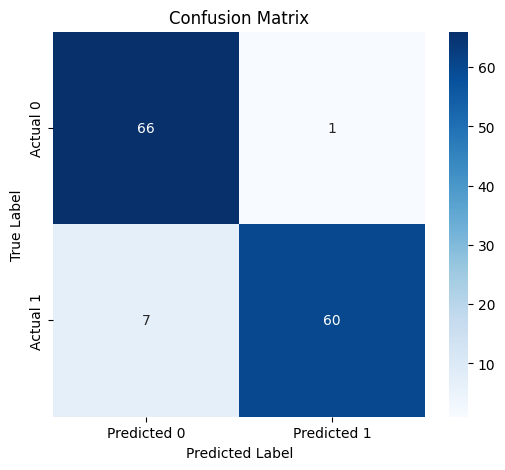

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 3.3.4 List of statements per category (TP, TN, FP, FN)

In [20]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [21]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 60)


,text
0,Study S7 (with French participants) employed a...
1,There was no correlation between CAPS score an...
2,"On the other hand, hunger and desire for food ..."
3,The number of observed individuals had no effe...
4,There was no interaction between age group and...
5,Medical maximizers showed greater belief in bo...
6,A rank-based Spearman's correlation test (p < ...
7,Chronic stress did not modulate the effect of ...
8,RT data showed a very similar pattern: Respons...
9,"Comparing these correlation coefficients, we f..."


In [22]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 66)


,text
0,"In contrast, there were no significant group d..."
1,We found that sounds did not have a significan...
2,"Following up, we found that sounds had no sign..."
3,"This difference, however, was highly significa..."
4,The interaction between familiarity and length...
...,...
61,The difference between the boost+ condition (M...
62,Thus there is no significant relationship betw...
63,No significant gender differences emerged in a...
64,The effect of oral contraceptive use was not s...


In [23]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 1)


,text
0,No main effect of dimensionality was found (3D...


In [24]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 7)


,text
0,"On the other hand, the quadratic component of ..."
1,"Likewise, there is no significant differences ..."
2,"No difference was found in verbal tests, t(343..."
3,"The three-way interaction was not significant,..."
4,"Crucially, we found no correlation between the..."
5,"The model was not significant, Ï‡ 2 (3, N = 90..."
6,There was no significant main effect of the se...


## 4. SciBERT

### 4.1 Initializing SciBERT

In [25]:
from transformers import AutoModelForSequenceClassification

model_scibert = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=num_labels, trust_remote_code=True,
    use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 4.2 Training SciBERT

In [26]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_scibert = Trainer(
    model=model_scibert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_15220\2136063693.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_scibert = Trainer(


In [27]:
trainer_scibert.train()

Step,Training Loss
67,0.724000
134,0.565300
201,0.370700
268,0.207100
335,0.109700


TrainOutput(global_step=335, training_loss=0.3953793027507725, metrics={'train_runtime': 129.36, 'train_samples_per_second': 20.64, 'train_steps_per_second': 2.59, 'total_flos': 380067002800200.0, 'train_loss': 0.3953793027507725, 'epoch': 5.0})

#### 4.2.1 Save last model

In [28]:
# trainer_scibert.save_model('scibert_model')

### 4.3 Evaluate model

#### 4.3.1 Predict training data

In [29]:
from sklearn.metrics import classification_report

preds = trainer_scibert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       267
           1       0.99      0.99      0.99       267

    accuracy                           0.99       534
   macro avg       0.99      0.99      0.99       534
weighted avg       0.99      0.99      0.99       534



#### 4.3.2 Predict test data

In [30]:
preds = trainer_scibert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.86      0.81      0.83        67
           1       0.82      0.87      0.84        67

    accuracy                           0.84       134
   macro avg       0.84      0.84      0.84       134
weighted avg       0.84      0.84      0.84       134



#### 4.3.3 Confusion-Matrix for test data

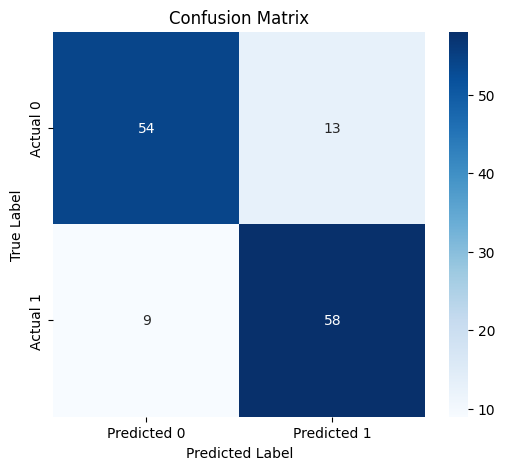

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 4.3.4 List of statements per category (TP, TN, FP, FN)

In [32]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [33]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 58)


,text
0,There was no correlation between CAPS score an...
1,"On the other hand, hunger and desire for food ..."
2,The number of observed individuals had no effe...
3,There was no interaction between age group and...
4,Medical maximizers showed greater belief in bo...
5,"On the other hand, the quadratic component of ..."
6,A rank-based Spearman's correlation test (p < ...
7,Chronic stress did not modulate the effect of ...
8,RT data showed a very similar pattern: Respons...
9,"Comparing these correlation coefficients, we f..."


In [34]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 54)


,text
0,"In contrast, there were no significant group d..."
1,We found that sounds did not have a significan...
2,"Following up, we found that sounds had no sign..."
3,"This difference, however, was highly significa..."
4,The interaction between familiarity and length...
5,"However, no effect of arousal was found for un..."
6,The receivers' zygomatic activity during touch...
7,Meta-regression indicated no significant moder...
8,Incongruent evaluations did not differ signifi...
9,"Interestingly, here congruent imagery did not ..."


In [35]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 13)


,text
0,No main effect of dimensionality was found (3D...
1,We found no effect of p(probe key|incongruent)...
2,Post hoc examination of the interaction did no...
3,"The main effect of aperture, Experiment 2: F(1..."
4,"For congruency, larger EPN amplitudes (incongr..."
5,A Mantel-Cox log rank test indicated that wait...
6,"Replicating Experiments 1 and 2, results showe..."
7,"Again, results indicated that endorsement of d..."
8,Participants in the time-pressure condition (n...
9,"But, most important, the slope at 45Â° was not..."


In [36]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 9)


,text
0,Study S7 (with French participants) employed a...
1,"Likewise, there is no significant differences ..."
2,"No difference was found in verbal tests, t(343..."
3,"Conversely, and as predicted, the explicit rel..."
4,"The three-way interaction was not significant,..."
5,"Crucially, we found no correlation between the..."
6,"The model was not significant, Ï‡ 2 (3, N = 90..."
7,There was no significant main effect of the se...
8,"Viewed differently, participants disliked avoi..."


## 5. PubMedBERT

### 5.1 Initializing PubMedBERT

In [37]:
from transformers import AutoModelForSequenceClassification

model_pubmedbert = AutoModelForSequenceClassification.from_pretrained("microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract", num_labels=num_labels, trust_remote_code=True,
    use_safetensors=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 5.2 Training PubMedBERT

In [38]:
# Standard Setup for training a model with Huggingface Transformers
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5, # Specify learning rate for BERT
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_strategy="epoch",
    report_to="none",
)

# Model specific setup
trainer_pubmedbert = Trainer(
    model=model_pubmedbert,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

C:\Users\Raphael\AppData\Local\Temp\ipykernel_15220\2526163365.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_pubmedbert = Trainer(


In [39]:
trainer_pubmedbert.train()

Step,Training Loss
67,0.719500
134,0.657700
201,0.440600
268,0.247300
335,0.143800


TrainOutput(global_step=335, training_loss=0.4417722531219027, metrics={'train_runtime': 141.7564, 'train_samples_per_second': 18.835, 'train_steps_per_second': 2.363, 'total_flos': 380067002800200.0, 'train_loss': 0.4417722531219027, 'epoch': 5.0})

#### 5.2.1 Save last model

In [40]:
# trainer_pubmedbert.save_model('pubmedbert_model')

### 5.3 Evaluate model

#### 5.3.1 Predict training data

In [41]:
from sklearn.metrics import classification_report

preds = trainer_pubmedbert.predict(tokenized_train)
preds = np.argmax(preds[:3][0],axis=1)
GT = df_train['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       267
           1       0.97      0.99      0.98       267

    accuracy                           0.98       534
   macro avg       0.98      0.98      0.98       534
weighted avg       0.98      0.98      0.98       534



#### 5.3.2 Predict test data

In [42]:
preds = trainer_pubmedbert.predict(tokenized_test)
preds = np.argmax(preds[:3][0],axis=1) #preds[:3][1]
GT = df_test['label'].tolist()
print(classification_report(GT,preds))

              precision    recall  f1-score   support

           0       0.84      0.72      0.77        67
           1       0.75      0.87      0.81        67

    accuracy                           0.79       134
   macro avg       0.80      0.79      0.79       134
weighted avg       0.80      0.79      0.79       134



#### 5.3.3 Confusion-Matrix for test data

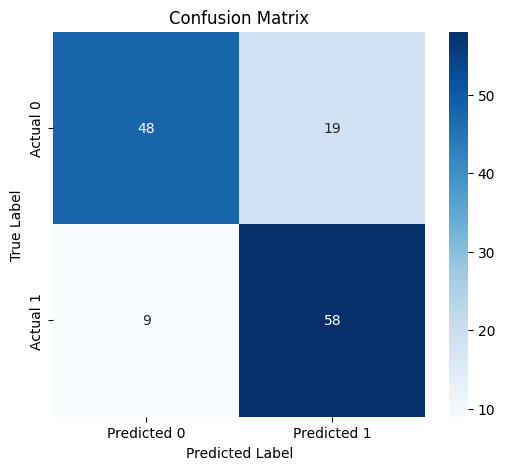

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Use predictions and ground truth from previous evaluation on test set
conf_matrix = confusion_matrix(GT, preds)

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["Actual 0", "Actual 1"])

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### 5.3.4 List of statements per category (TP, TN, FP, FN)

In [44]:
# Get ground truth and predictions for test set
y_true = df_test['label'].tolist()
y_pred = preds

# True Positives: predicted 1, actual 1
true_positives = df_test[(df_test['label'] == 1) & (y_pred == 1)]

# True Negatives: predicted 0, actual 0
true_negatives = df_test[(df_test['label'] == 0) & (y_pred == 0)]

# False Positives: predicted 1, actual 0
false_positives = df_test[(df_test['label'] == 0) & (y_pred == 1)]

# False Negatives: predicted 0, actual 1
false_negatives = df_test[(df_test['label'] == 1) & (y_pred == 0)]

# Function to print statements
import pandas as pd
from IPython.display import display

def display_statements(df, title):
    if not df.empty:
        print(f"\n{title} (count: {len(df)})")
        display(df[['text']].reset_index(drop=True))
    else:
        print(f"\n{title}: None")

In [45]:
display_statements(true_positives, "True Positives (predicted 1, actual 1)")


True Positives (predicted 1, actual 1) (count: 58)


,text
0,Study S7 (with French participants) employed a...
1,There was no correlation between CAPS score an...
2,"On the other hand, hunger and desire for food ..."
3,The number of observed individuals had no effe...
4,There was no interaction between age group and...
5,Medical maximizers showed greater belief in bo...
6,"On the other hand, the quadratic component of ..."
7,A rank-based Spearman's correlation test (p < ...
8,Chronic stress did not modulate the effect of ...
9,RT data showed a very similar pattern: Respons...


In [46]:
display_statements(true_negatives, "True Negatives (predicted 0, actual 0)")


True Negatives (predicted 0, actual 0) (count: 48)


,text
0,"In contrast, there were no significant group d..."
1,We found that sounds did not have a significan...
2,"Following up, we found that sounds had no sign..."
3,"This difference, however, was highly significa..."
4,The interaction between familiarity and length...
5,The receivers' zygomatic activity during touch...
6,Meta-regression indicated no significant moder...
7,Incongruent evaluations did not differ signifi...
8,"Interestingly, here congruent imagery did not ..."
9,"Consequently, receivers' use of the odd-oneout..."


In [47]:
display_statements(false_positives, "False Positives (predicted 1, actual 0)")


False Positives (predicted 1, actual 0) (count: 19)


,text
0,No main effect of dimensionality was found (3D...
1,"However, no effect of arousal was found for un..."
2,We found no effect of p(probe key|incongruent)...
3,"For the CFD stimuli, this contrast was not sig..."
4,"The main effect of aperture, Experiment 2: F(1..."
5,"For congruency, larger EPN amplitudes (incongr..."
6,A Mantel-Cox log rank test indicated that wait...
7,"Again, results indicated that endorsement of d..."
8,"But, most important, the slope at 45Â° was not..."
9,Fisher's r-to-z tests were significant for sev...


In [48]:
display_statements(false_negatives, "False Negatives (predicted 0, actual 1)")


False Negatives (predicted 0, actual 1) (count: 9)


,text
0,"In addition, LPIPS scores were not correlated ..."
1,"Likewise, there is no significant differences ..."
2,"Consistent with our expectations, results show..."
3,The third model added the remaining task varia...
4,"The model was not significant, Ï‡ 2 (3, N = 90..."
5,"Decoy selections did not depend on age, b = 0...."
6,There was no significant main effect of the se...
7,Simple-slopes analysis revealed that participa...
8,"Furthermore, we found that the nudge was effec..."


In [1]:
# The end...